In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
#Convert vector to image
def to_img(y):
    y=0.5*(y+1)
    y=y.view(y.size(0),28,28)
    return y

In [3]:
#Displaying routine
def display_images(in_,out,n=1):
    for N in range(n):
        if in_ is not None:
            in_pic=to_img(in_.cpu().data)
            plt.figure(figsize=(18,6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic=to_img(out.cpu().data)
        plt.figure(figsize=(18,6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
#Define data loading step
batch_size=256
img_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataset=MNIST('./data',transform=img_transform, download=True)
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [5]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#Define model architecture and reconstruction loss
#n=28*28=784
d=30 #for standard AE (under-complete hidden layer)
#d=500 #for denoising AE (over-complete hidden layer)
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Linear(28*28,d),
            nn.Tanh(),
        )
        self.decoder=nn.Sequential(
            nn.Linear(d,28*28),
            nn.Tanh(),
        )
    def forward(self,y):
        h=self.encoder(y)
        y=self.decoder(h) #ybar=self.decoder(h)
        return y #return ybar
ae=Autoencoder().to(device)
model=Autoencoder().to(device)
criterion=nn.MSELoss()

In [7]:
#Configure the optimiser
learning_rate=1e-3
optimizer=torch.optim.Adam(
    ae.parameters(),
    lr=learning_rate,
)

epoch[1/20],loss:0.2062
epoch[2/20],loss:0.1435
epoch[3/20],loss:0.1197
epoch[4/20],loss:0.0992
epoch[5/20],loss:0.0944
epoch[6/20],loss:0.0864
epoch[7/20],loss:0.0858
epoch[8/20],loss:0.0759
epoch[9/20],loss:0.0750
epoch[10/20],loss:0.0687
epoch[11/20],loss:0.0669
epoch[12/20],loss:0.0680
epoch[13/20],loss:0.0645
epoch[14/20],loss:0.0636
epoch[15/20],loss:0.0602
epoch[16/20],loss:0.0565
epoch[17/20],loss:0.0635
epoch[18/20],loss:0.0587
epoch[19/20],loss:0.0533
epoch[20/20],loss:0.0569


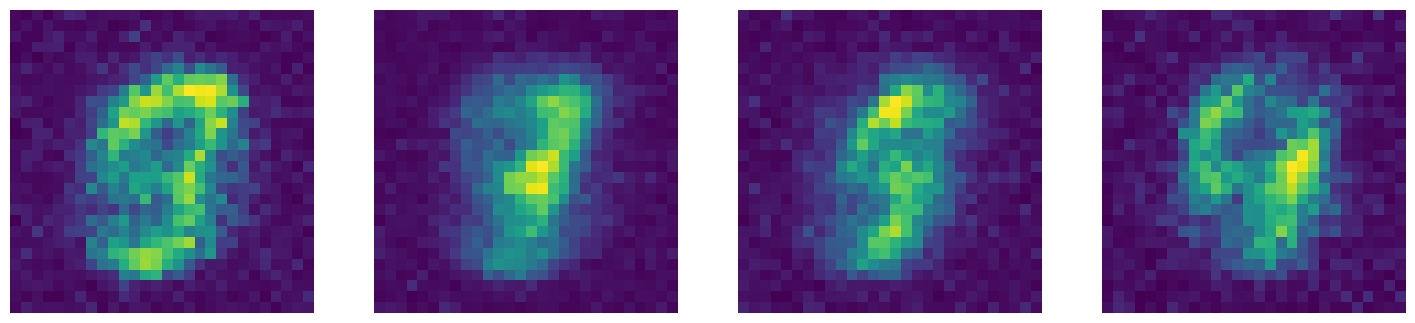

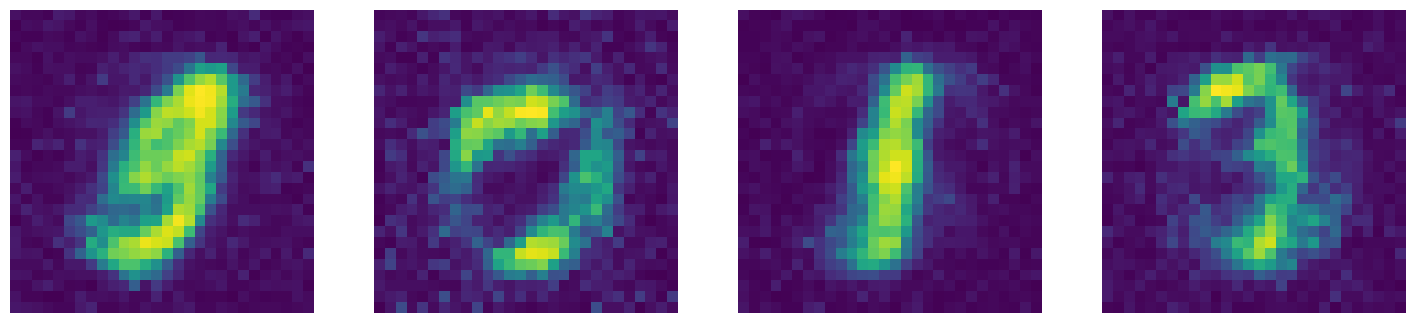

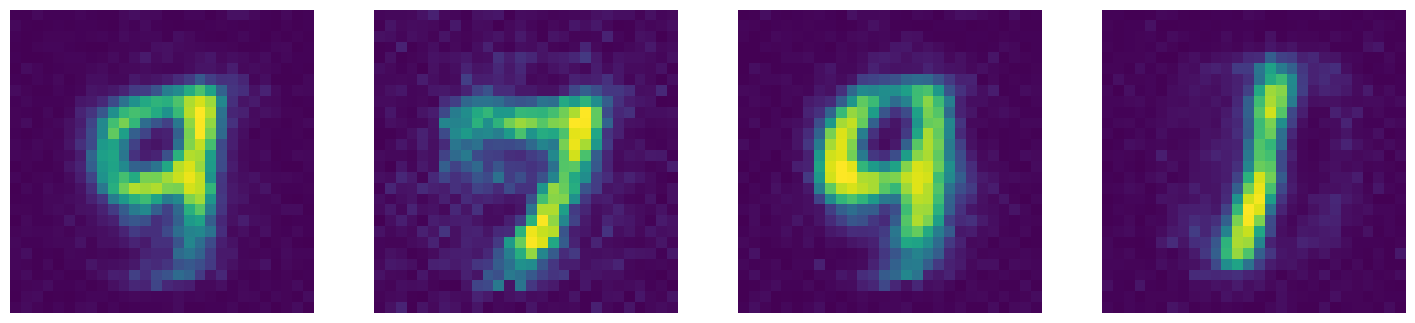

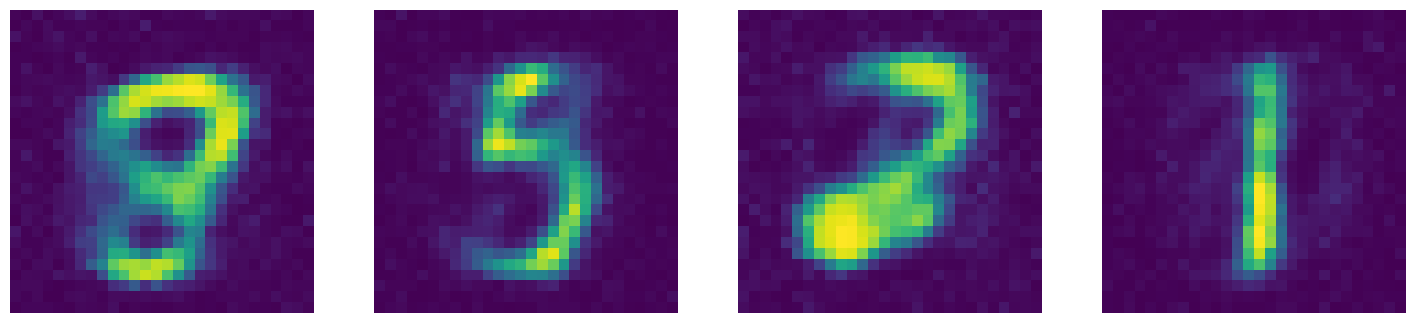

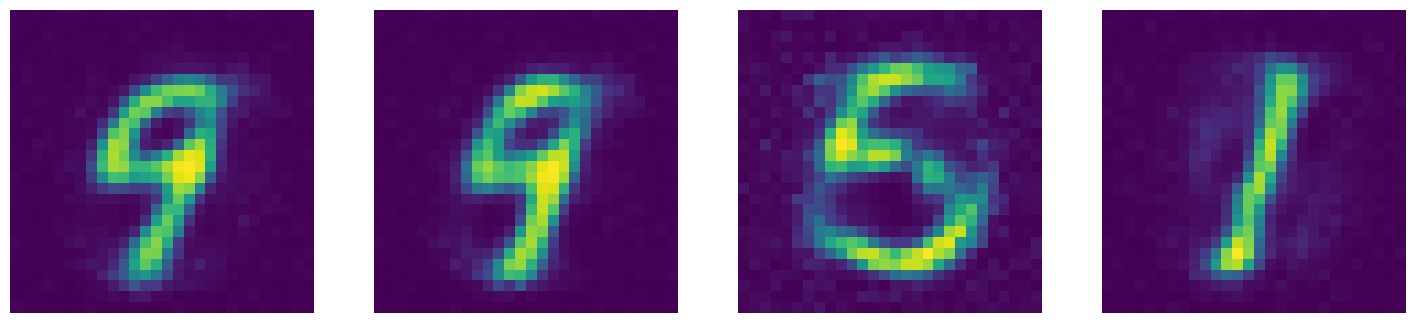

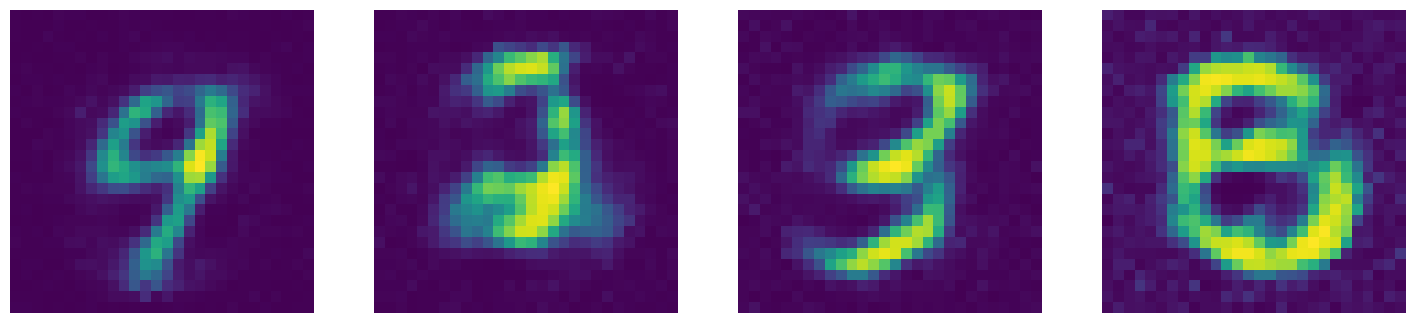

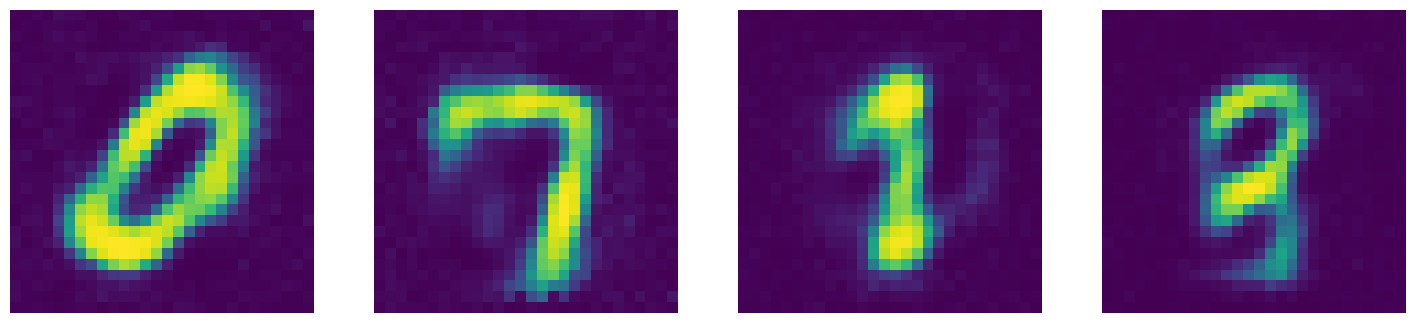

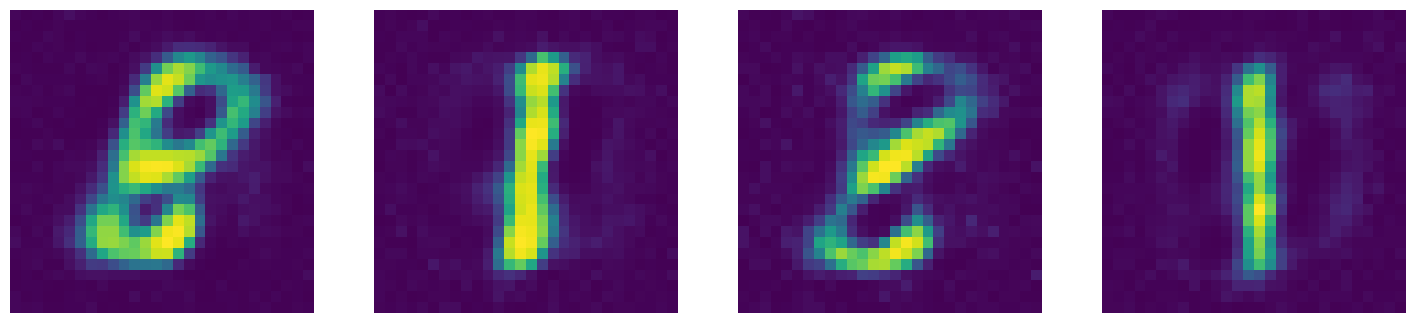

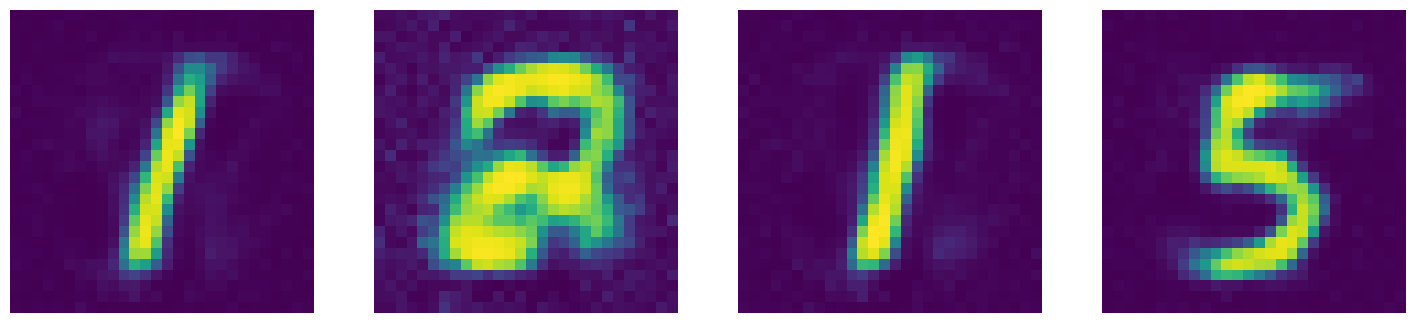

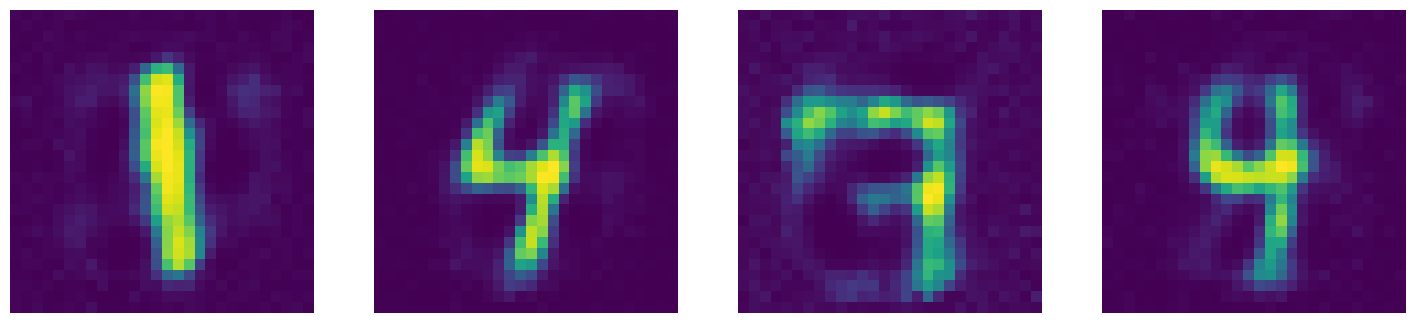

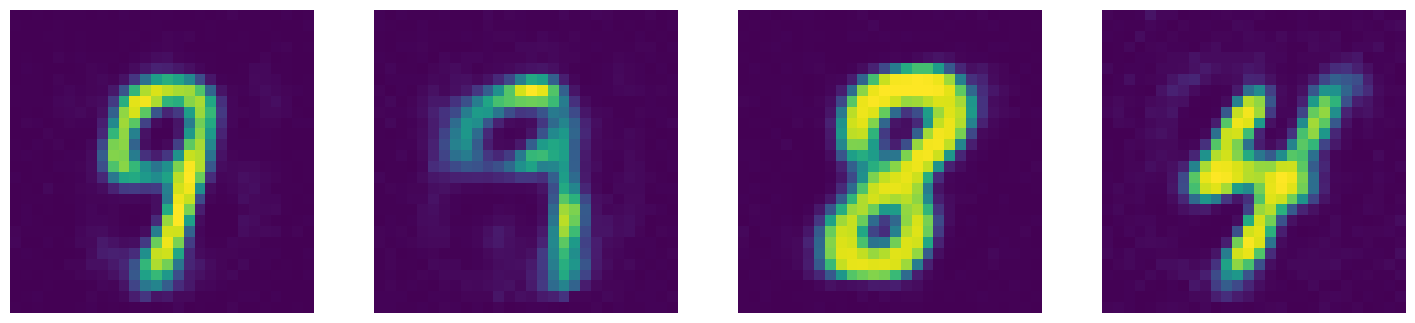

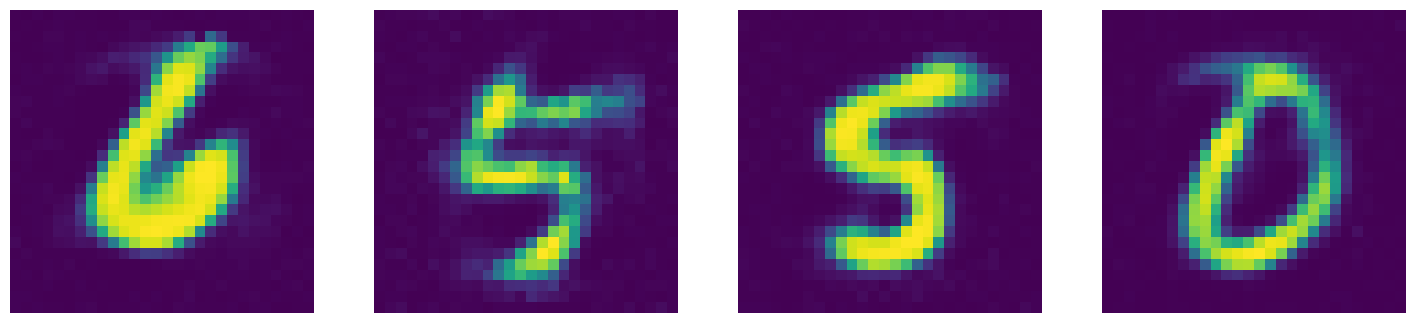

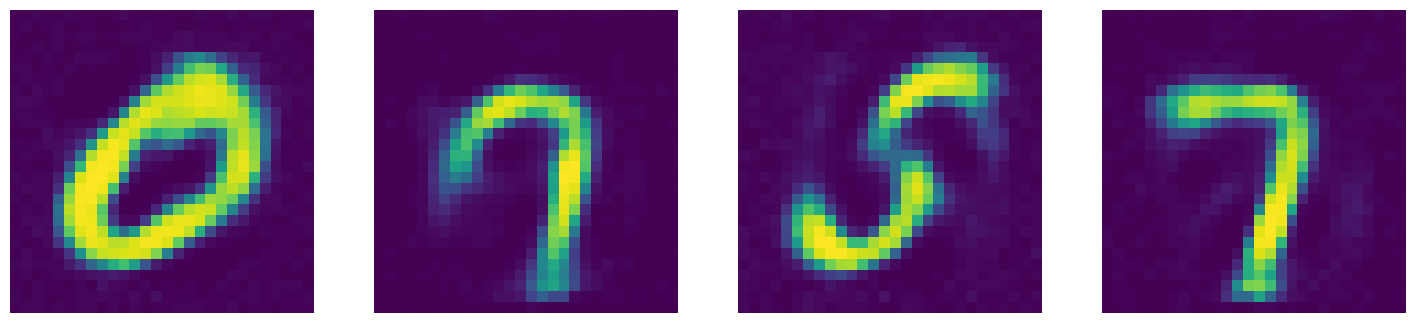

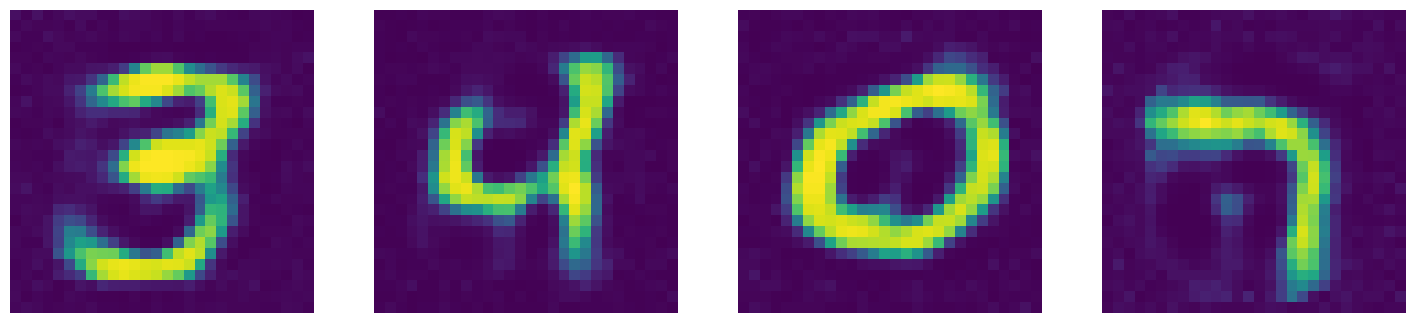

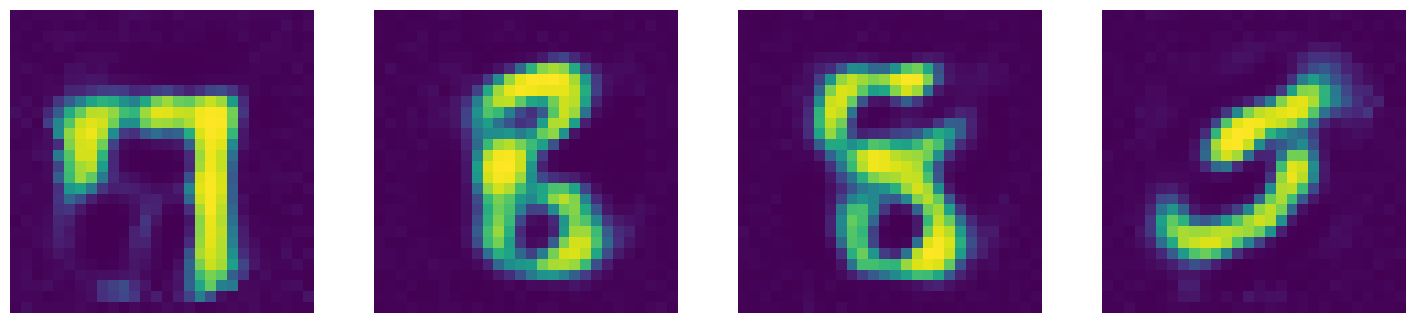

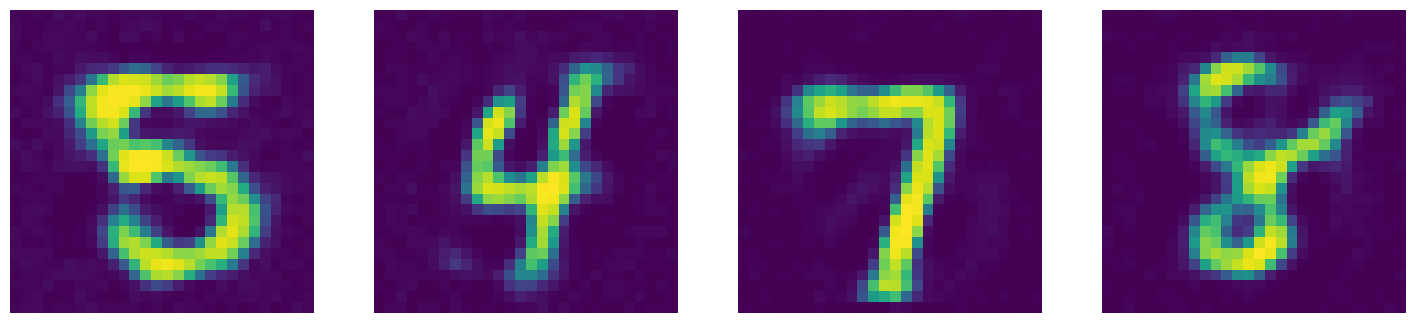

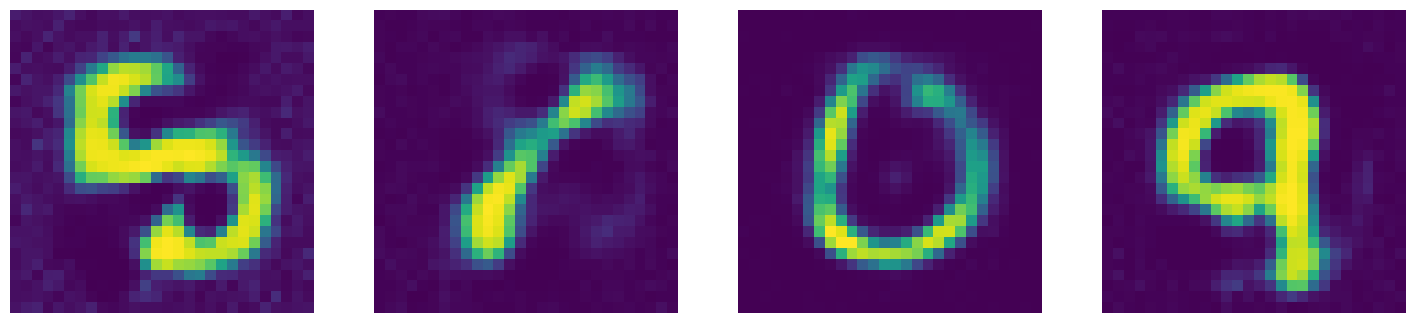

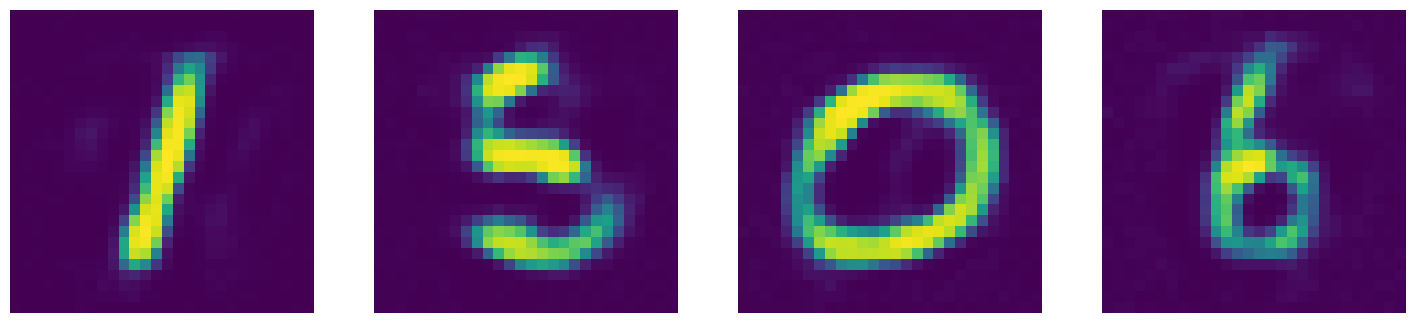

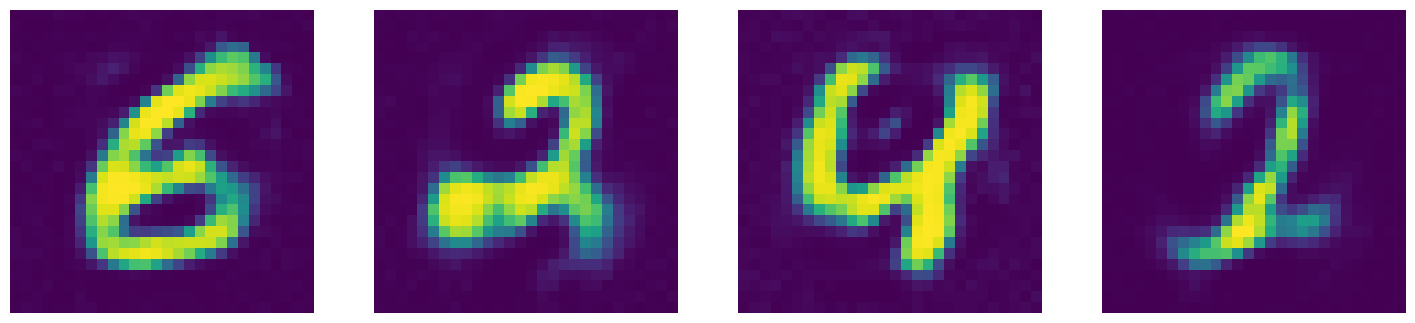

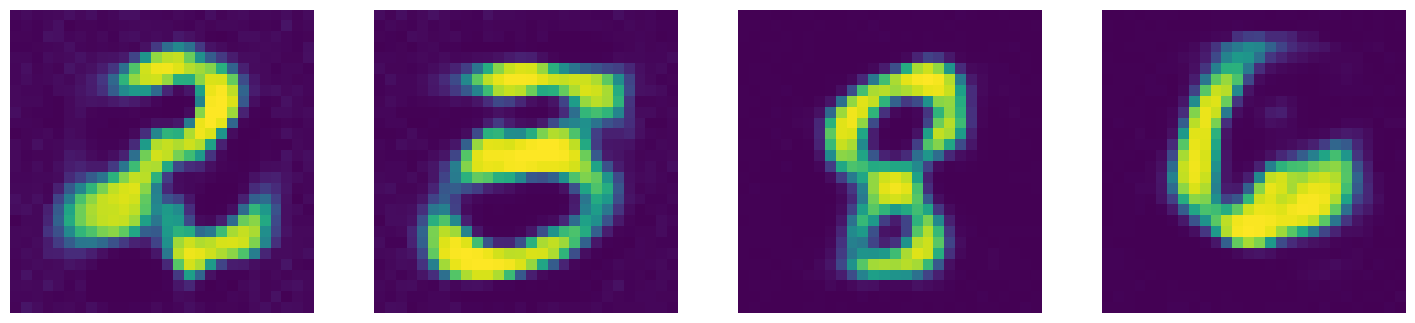

In [8]:
#Train standard autoencoder (AE)
num_epochs=20
#do=nn.Dropout() #comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img,_=data
        img=img.to(device)
        img=img.view(img.size(0),-1)
        #noise=do(torch.ones(img.shape)).to(device)
        #img_bad=(img*noise).to(device) #comment out for standard AE
        #============================================================
        output=ae(img) #feed <img> (for std AE) or <img_bad>
        loss=criterion(output,img.data)
        #============================================================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #================================================================
    print(f'epoch[{epoch+1}/{num_epochs}],loss:{loss.item():.4f}')
    display_images(None,output) #pass(None,output) for std AE,      

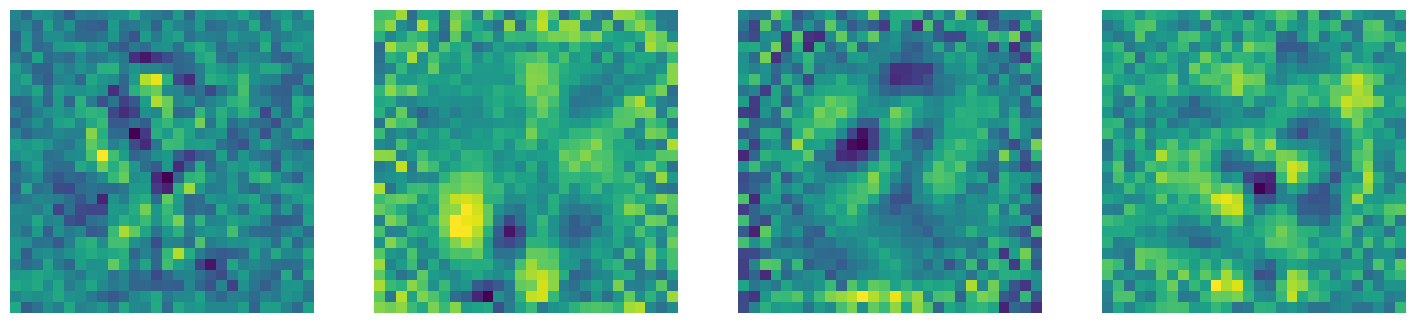

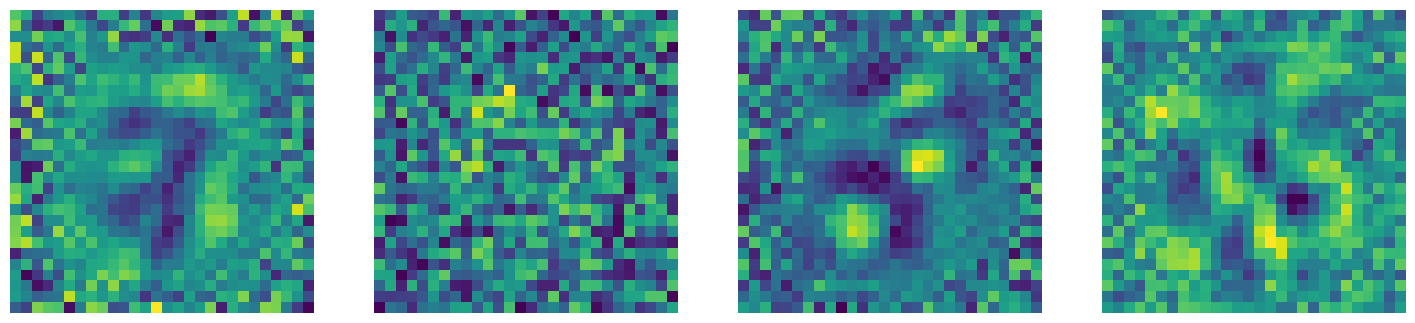

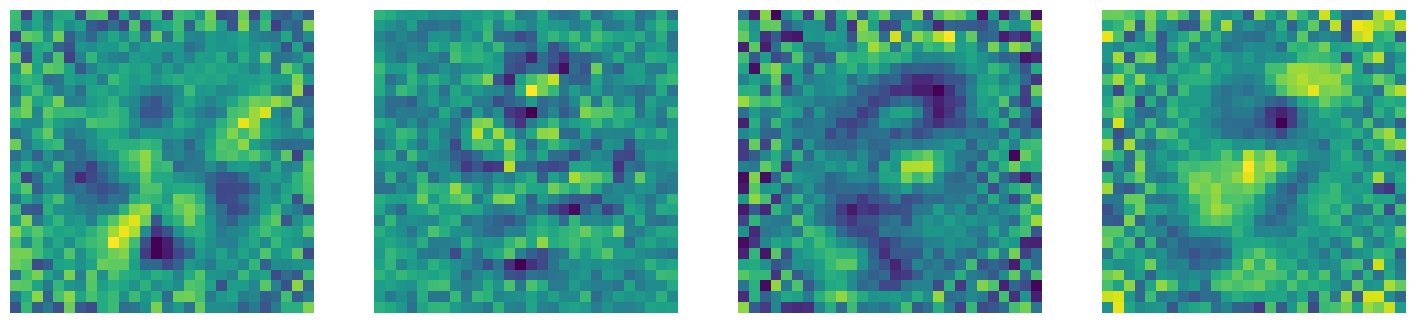

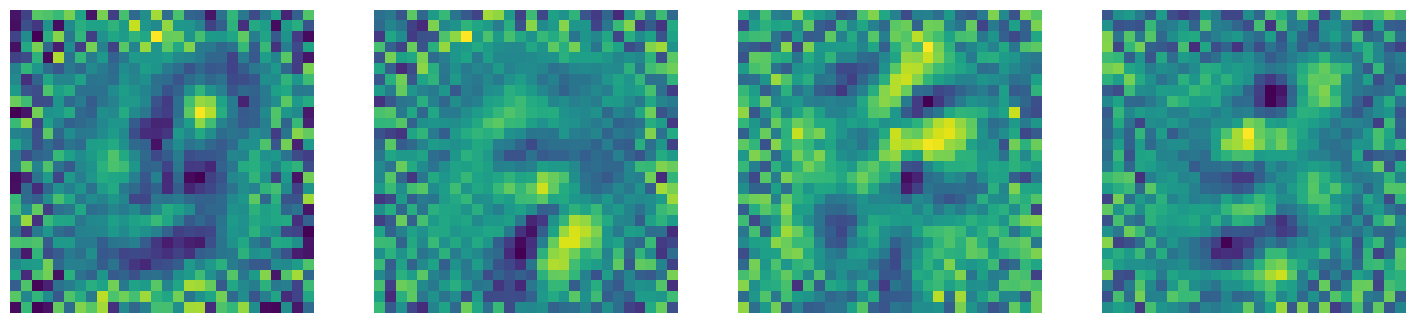

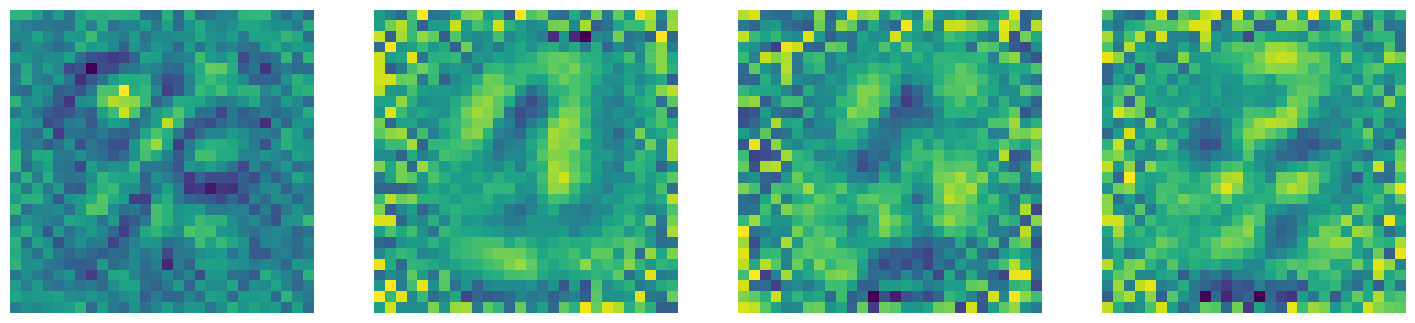

In [9]:
#Visualize a few kernels of the encoder
#model=Autoencoder()
display_images(None,ae.encoder[0].weight,5)

In [10]:
#Define model architecture and reconstruction loss
#n=28*28=784
#d=30 #for standard AE (under-complete hidden layer)
d=500 #for denoising AE (over-complete hidden layer)
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(
        nn.Linear(28*28,d),
        nn.Tanh(),
        )
        self.decoder=nn.Sequential(
        nn.Linear(d,28*28),
        nn.Tanh(),
        )
    def forward(self,y):
        h=self.encoder(y)
        y=self.decoder(h)
        return y
model=Autoencoder().to(device)
criterion=nn.MSELoss()

In [11]:
#Configure the optimiser
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epoch [1/5], loss:0.0720
epoch [2/5], loss:0.0688
epoch [3/5], loss:0.0701
epoch [4/5], loss:0.0715
epoch [5/5], loss:0.0663


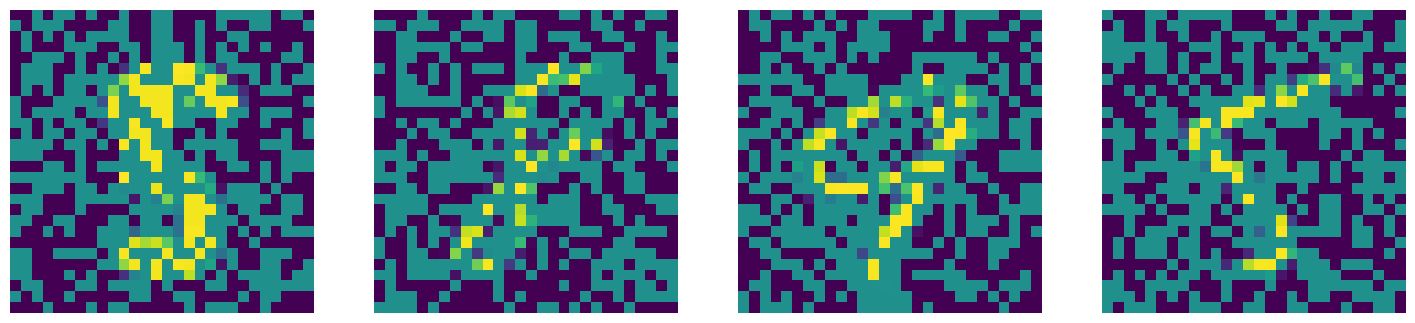

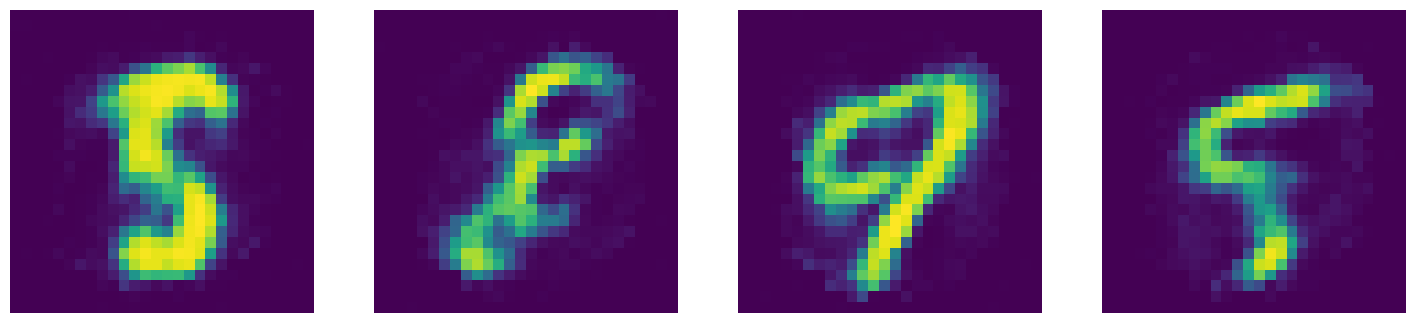

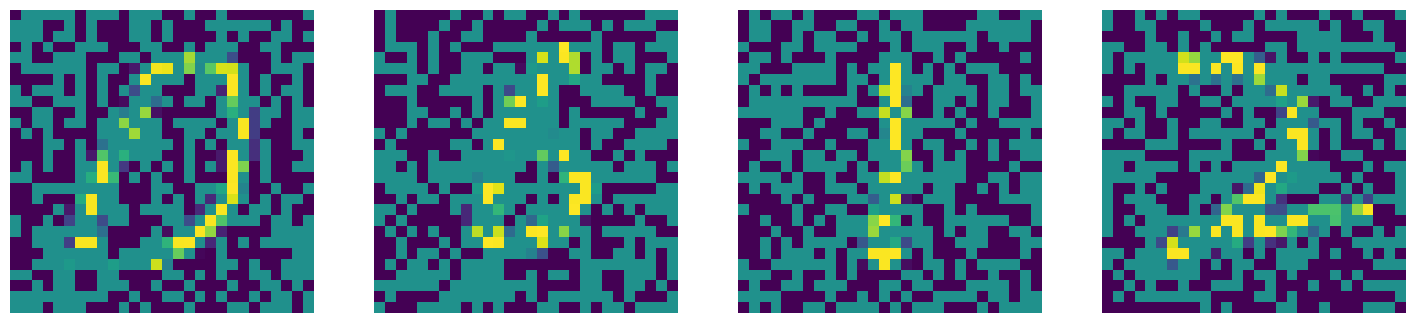

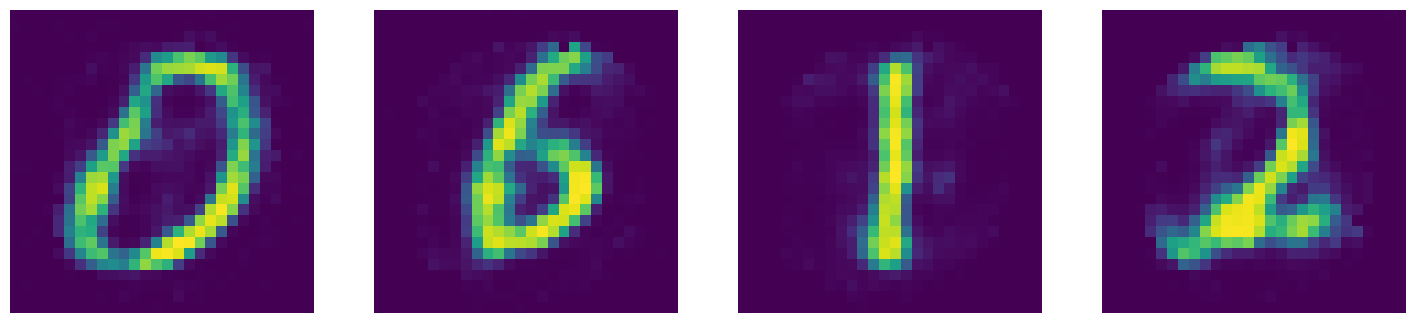

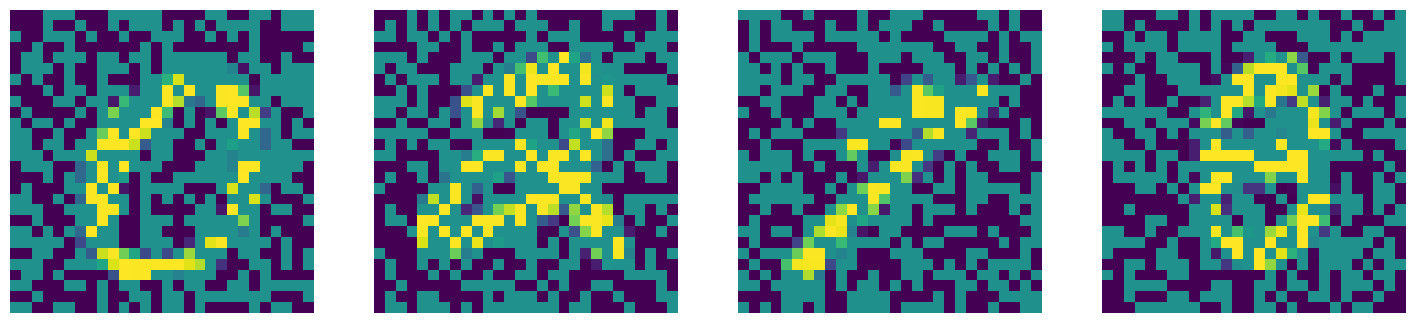

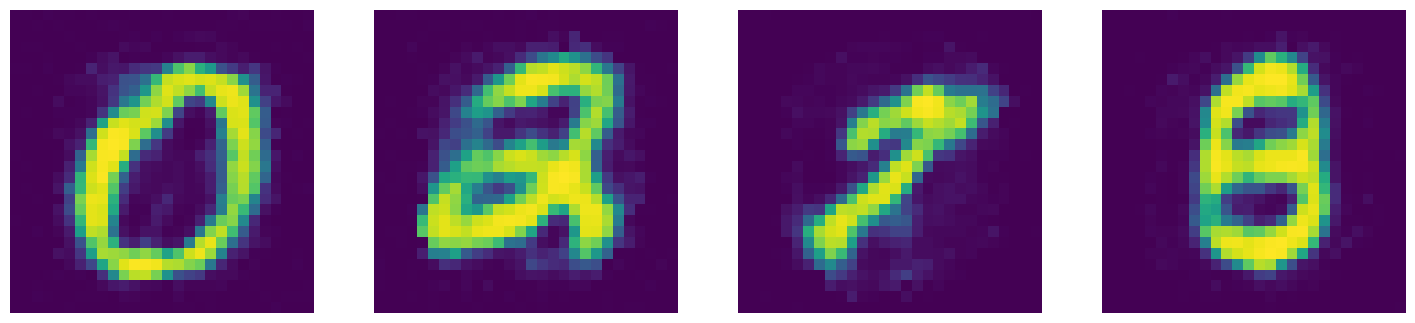

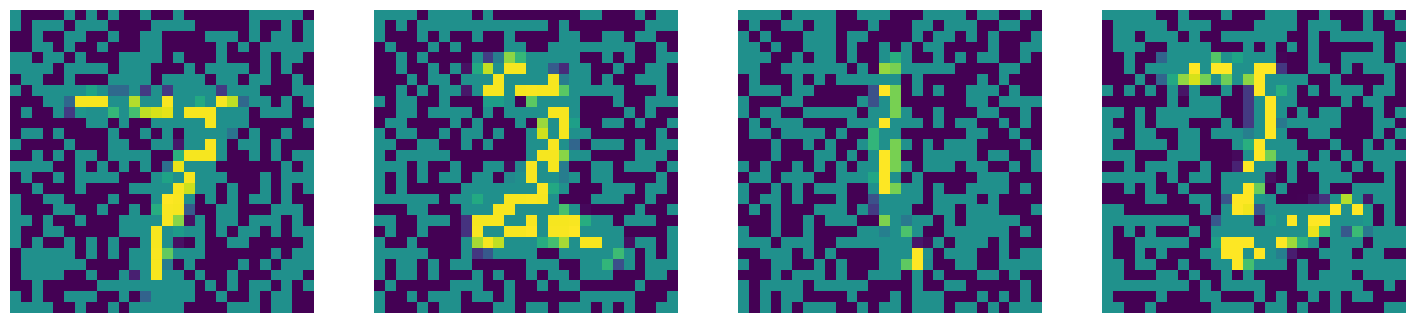

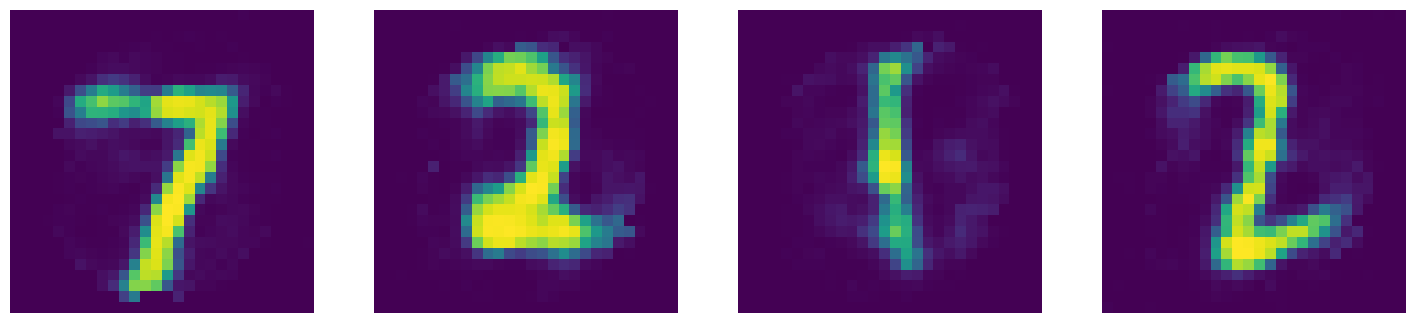

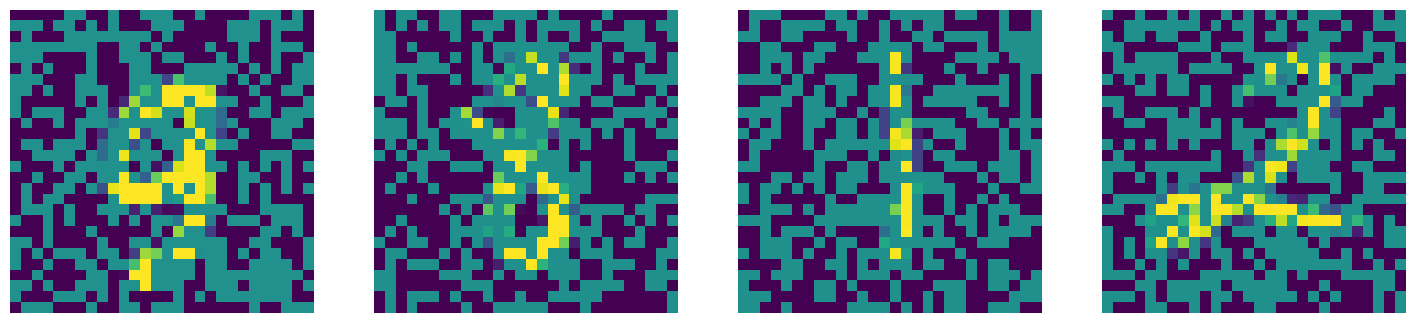

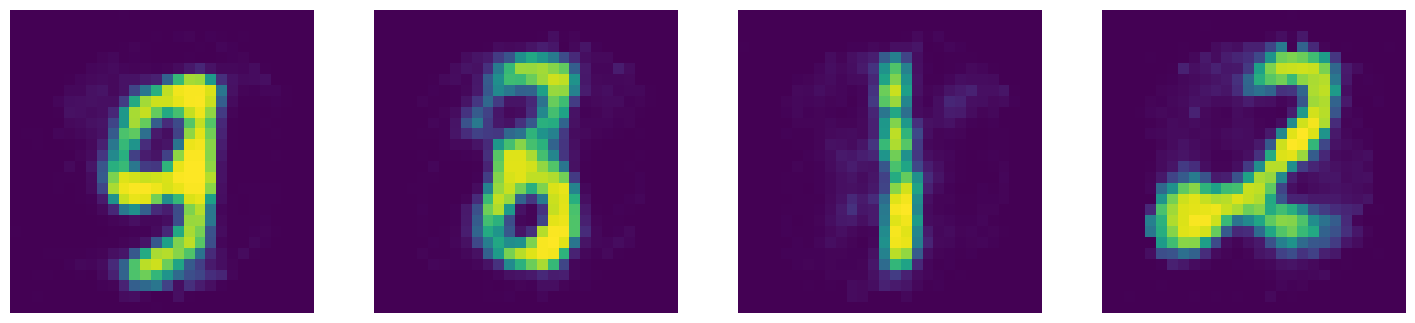

In [12]:
#Train denoising autoencoder (AE)
num_epochs = 5
do = nn.Dropout() # comment out for standard AE
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ =data
        img = img.to(device)
        img = img.view(img.size(0),-1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        # ==============forward=====================
        output = model(img_bad) # feed <img> (for std AE)
        loss = criterion(output, img.data)
        # ==============backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # =================log============================
    scheduler.step()
    print(f'epoch [{epoch+1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output) #pass (None, output) display_image(img_bad, output)

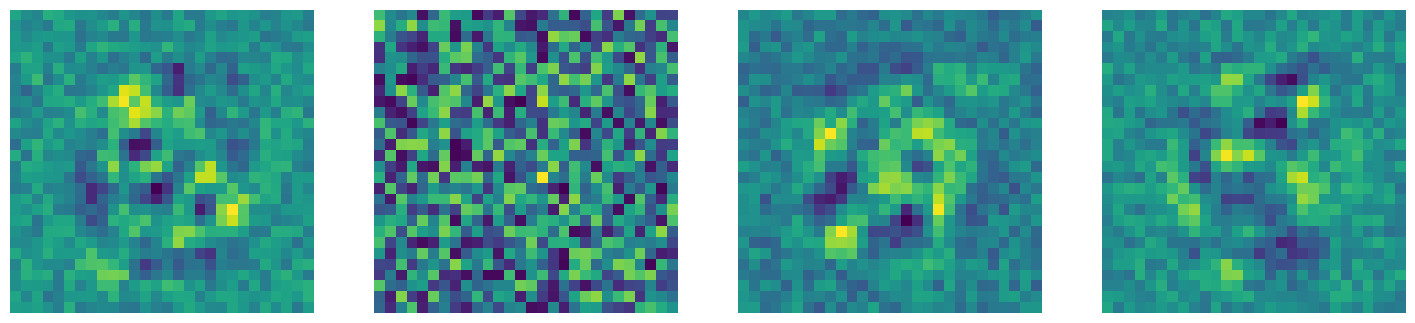

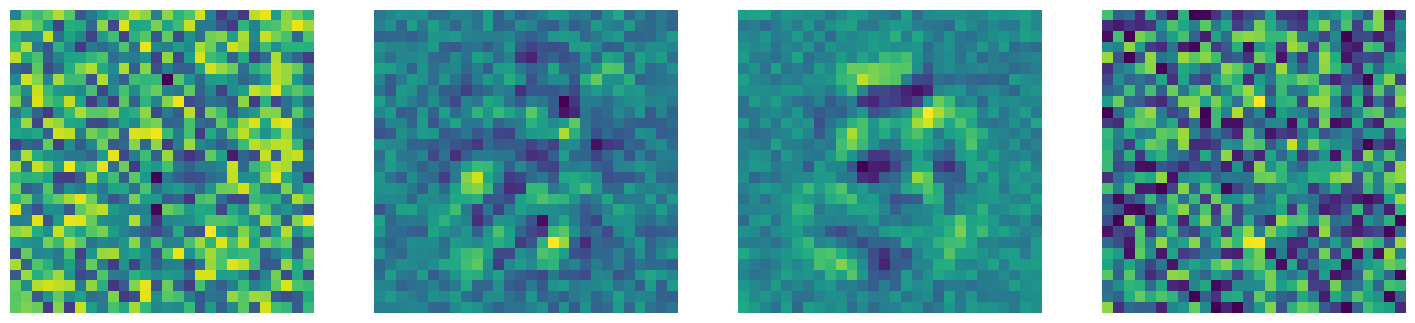

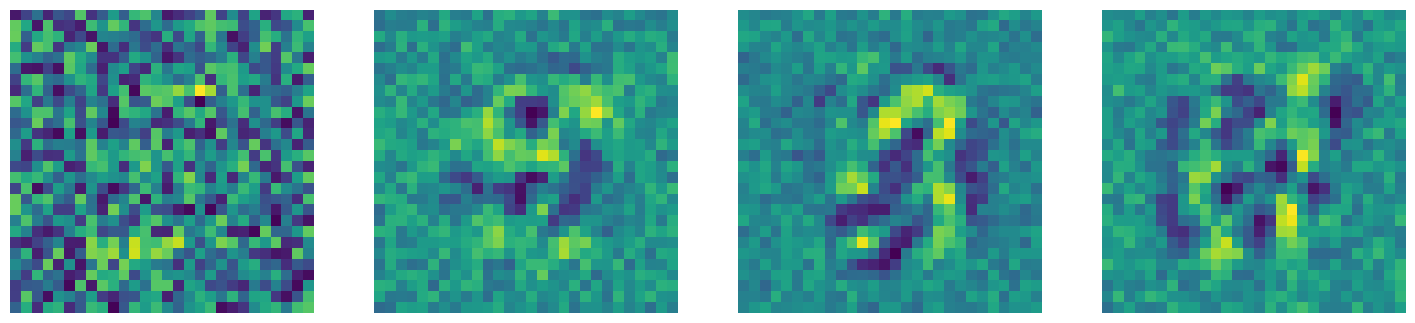

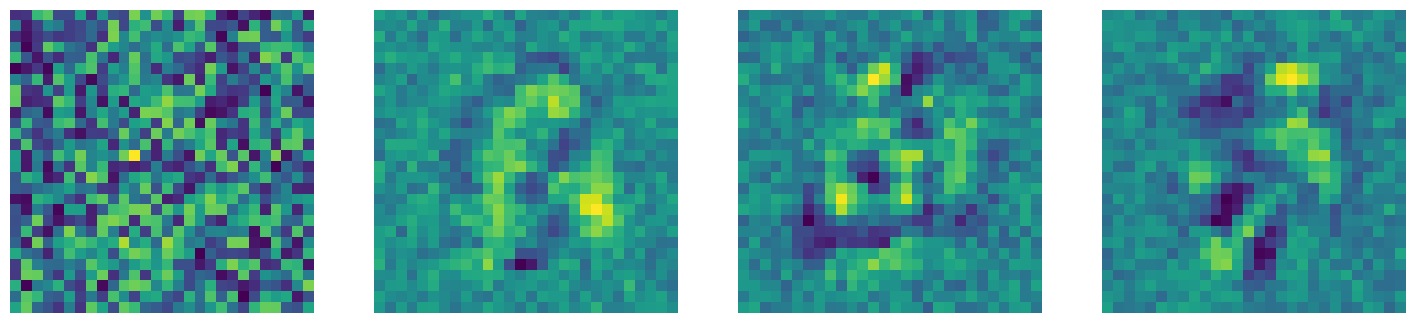

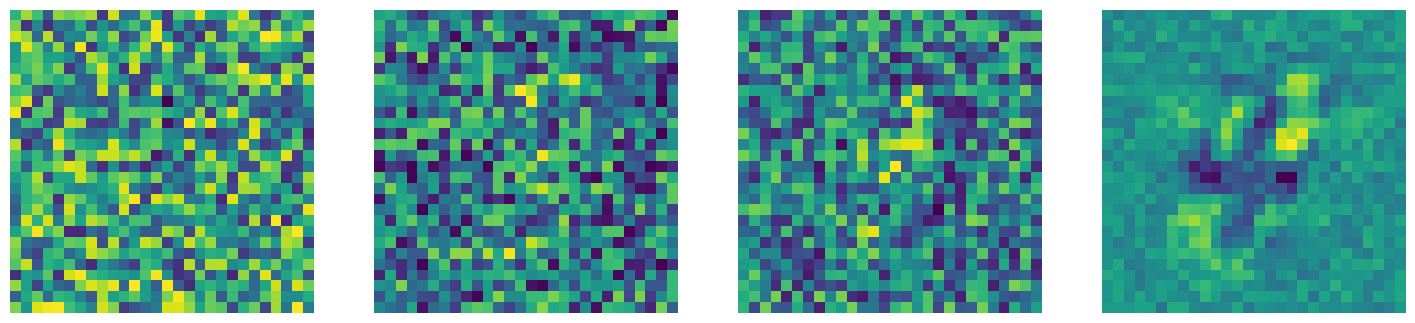

In [13]:
#Visualize a few kernels of the encoder
display_images(None, model.encoder[0].weight, 5)

In [14]:
# Compare the autoencoder impainting capabilities vs. OpenCV
import cv2
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [15]:
# Inpaint with Telea and Naiver-Stokes methods
dst_TELEA = list()
dst_NS =list()
for i in range(0,5):
    corrupted_img = ((img_bad.data.cpu()[i].view(28,28)/4+0.5)*i).numpy()
    mask = 2 - noise.cpu()[i].view(28,28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))
tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]
TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

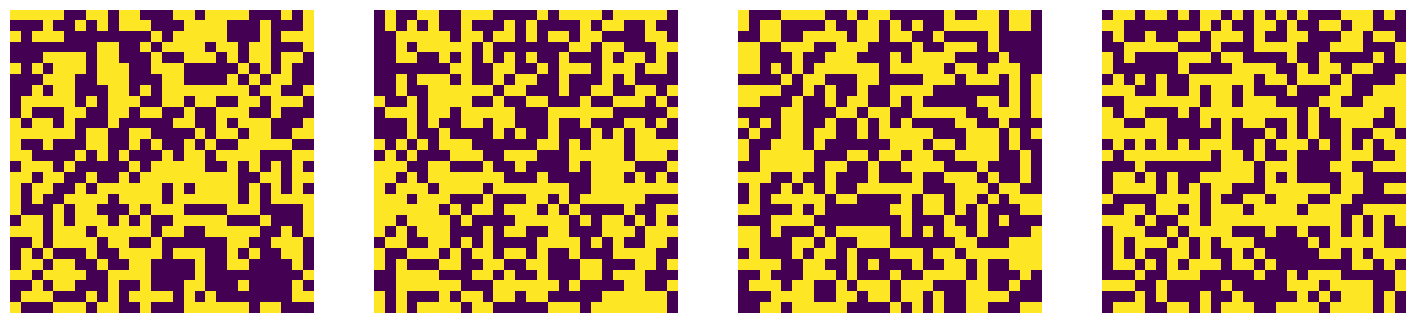

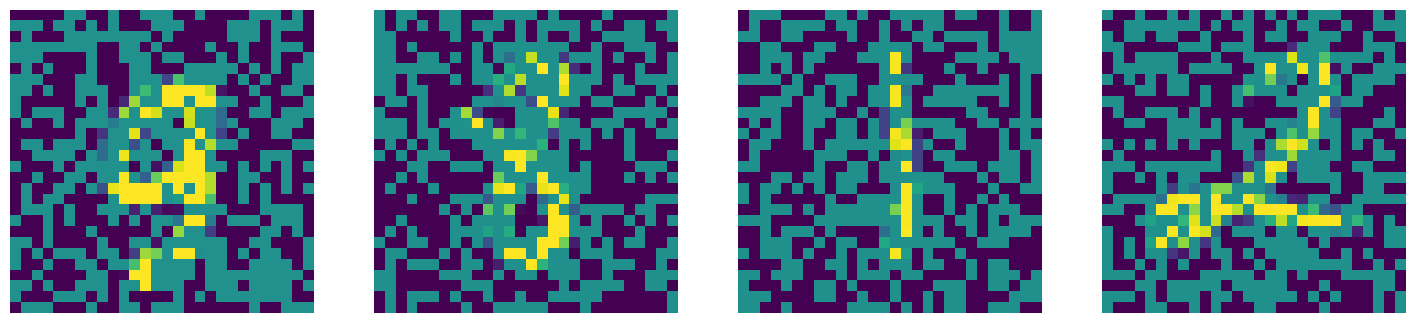

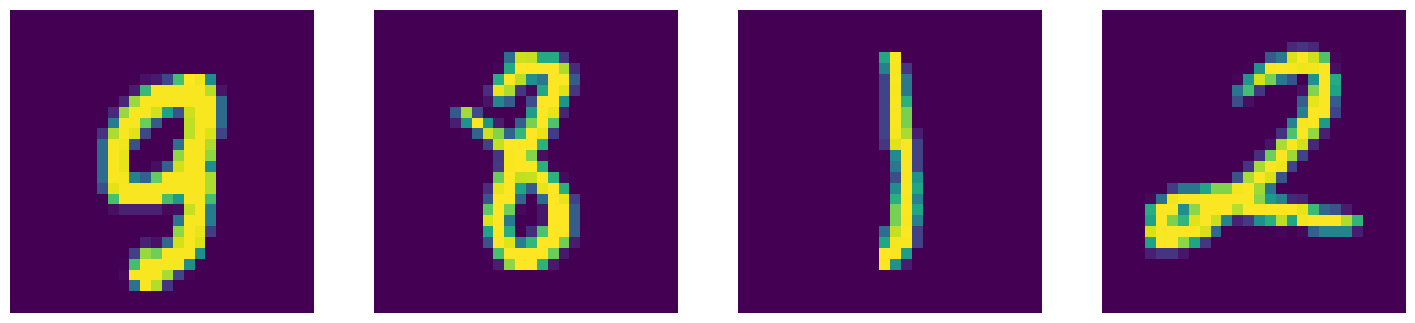

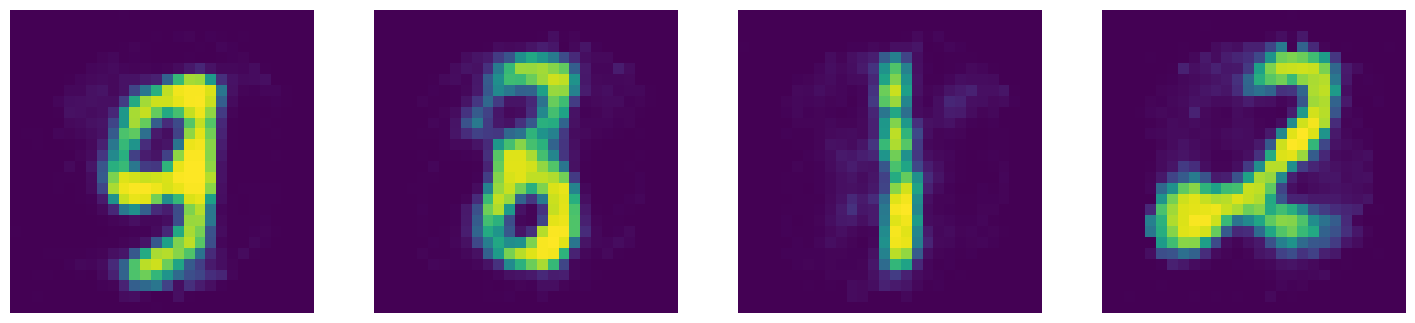

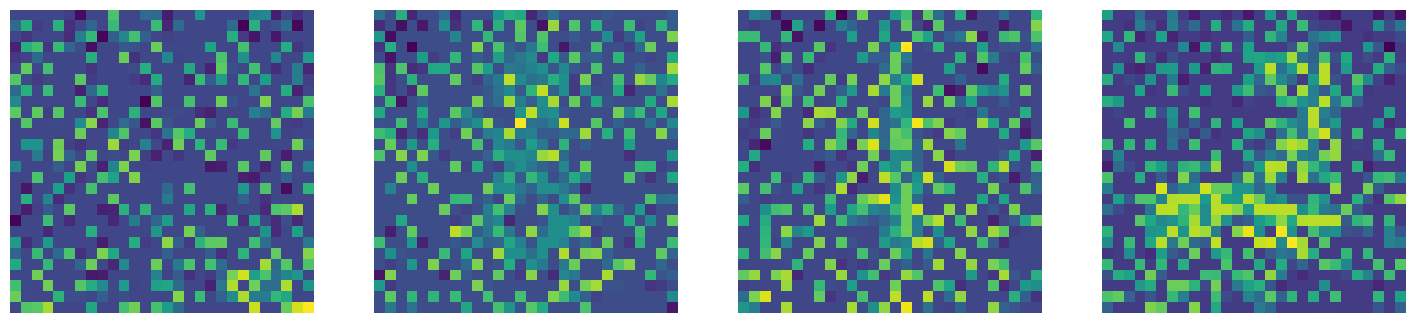

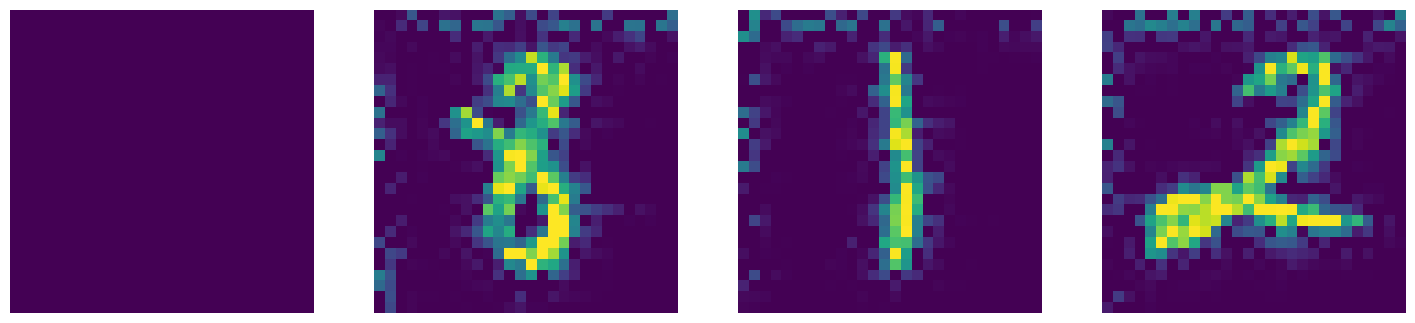

In [16]:
# Compare the results: [noise], [img+noise], [img], [AE, Telea]
with torch.no_grad():
    display_images(noise[0:5], img_bad[0:5])
    display_images(img[0:5], output[0:5])
    display_images(TELEA, NS)

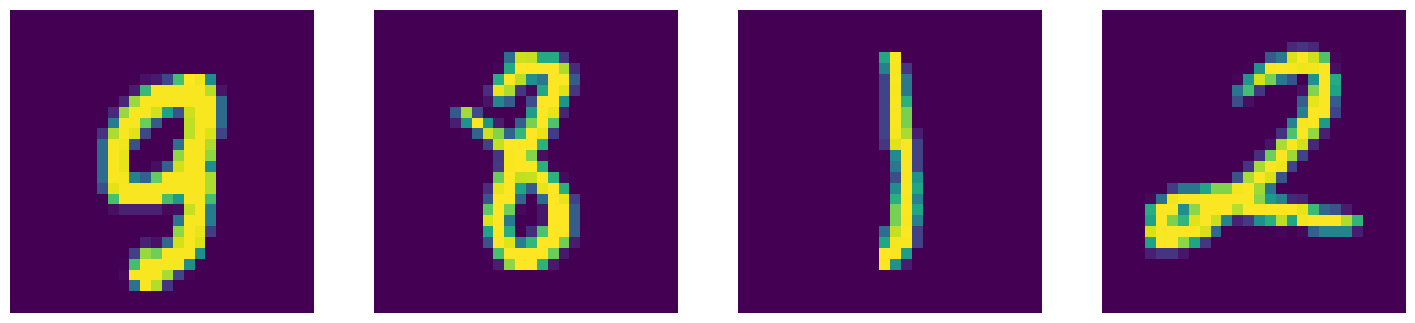

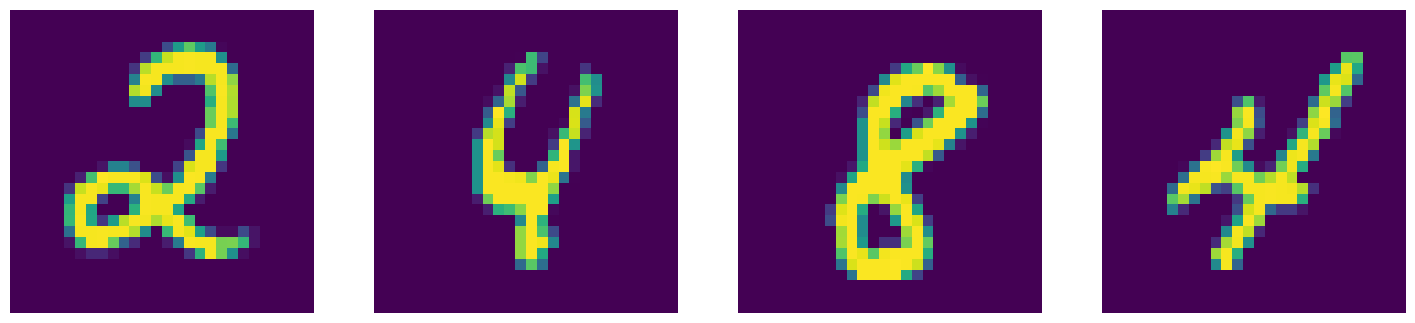

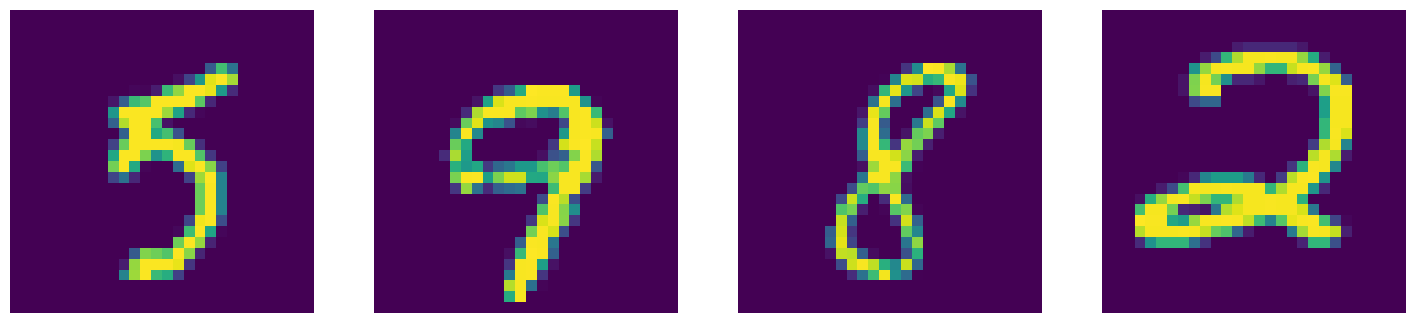

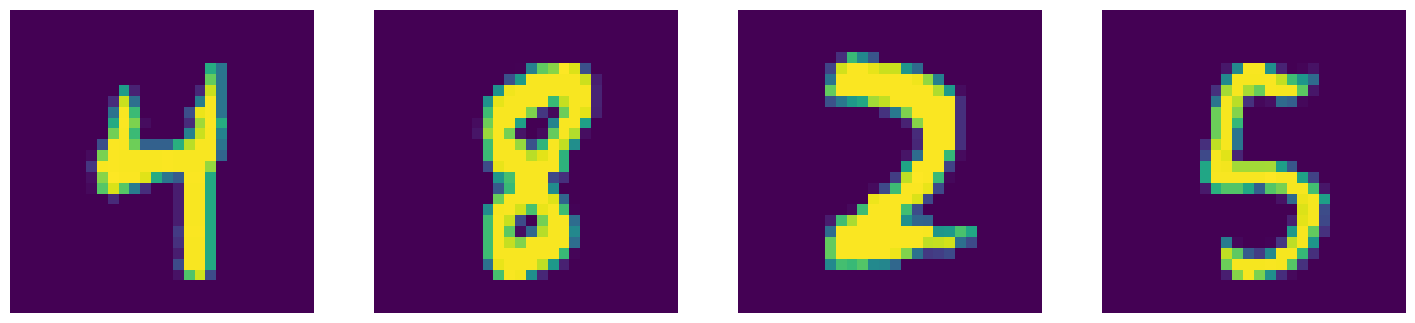

In [17]:
display_images(None, img, n=4)

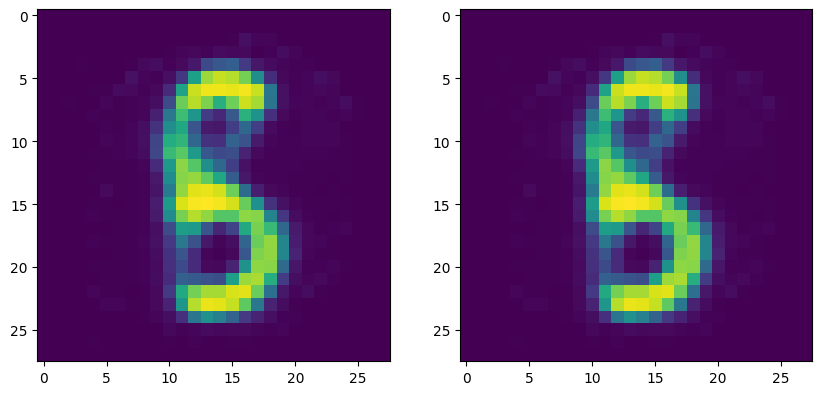

In [18]:
y = (img[1:2] + img[15:16])/2
with torch.no_grad():
    y = model(y)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(to_img(y).squeeze())
plt.subplot(122)
plt.imshow(to_img(y).squeeze())